In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler, PowerTransformer

import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('data/raw/census_income.csv')
df.head(1)

id  age    sex    race       marital_status  relationship_label  \
0  1623   17   Male   White   Married-civ-spouse                   0   

  relationship  functional_weight education  education_num workclass  \
0      Husband             221129       9th              5   Private   

       occupation  capital_gain  capital_loss  hours_per_week  native_country  \
0   Other-service             0             0              40              39   

     country_name  target  
0   United-States   <=50K

In [4]:
# V 3
columns_to_drop = ['id', ]
df.drop(columns_to_drop, axis = 1, inplace = True)
df.head(1)

age    sex    race       marital_status  relationship_label relationship  \
0   17   Male   White   Married-civ-spouse                   0      Husband   

   functional_weight education  education_num workclass      occupation  \
0             221129       9th              5   Private   Other-service   

   capital_gain  capital_loss  hours_per_week  native_country    country_name  \
0             0             0              40              39   United-States   

   target  
0   <=50K

In [5]:
# LabelEncoder for 'TARGET' column
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])
df.head(1)

age    sex    race       marital_status  relationship_label relationship  \
0   17   Male   White   Married-civ-spouse                   0      Husband   

   functional_weight education  education_num workclass      occupation  \
0             221129       9th              5   Private   Other-service   

   capital_gain  capital_loss  hours_per_week  native_country    country_name  \
0             0             0              40              39   United-States   

   target  
0       0

### Divide raw data on two sets for Train/Test and Validation model pipeline

In [6]:
# 'data_raw' use for train,  'validation_data' use for validatoin models 

data_raw, validation_data = train_test_split( df, test_size=0.01, random_state=42) 

In [7]:
# Create file
data_raw.to_csv('data/raw/raw_data_for_pipeline_v2.csv', index=False) # save as csv file
validation_data.to_csv('data/raw/raw_data_for_validation_pipeline_v2.csv', index=False)

In [8]:
data_raw.describe()

age  relationship_label  functional_weight  education_num  \
count  32235.000000        32235.000000       3.223500e+04   32235.000000   
mean      38.581294            1.444579       1.896642e+05      10.079417   
std       13.641227            1.605987       1.054796e+05       2.573006   
min       17.000000            0.000000       1.228500e+04       1.000000   
25%       28.000000            0.000000       1.177890e+05       9.000000   
50%       37.000000            1.000000       1.783410e+05      10.000000   
75%       48.000000            3.000000       2.369910e+05      12.000000   
max       90.000000            5.000000       1.484705e+06      16.000000   

       capital_gain  capital_loss  hours_per_week  native_country  \
count  32235.000000  32235.000000    32235.000000    32235.000000   
mean    1082.504700     87.123375       40.430029       36.721204   
std     7417.829732    402.693110       12.333433        7.822215   
min        0.000000      0.000000        1.000000        0.000000   
25%        0.000000      0.000000       40.000000       39.000000   
50%        0.000000      0.000000       40.000000       39.000000   
75%        0.000000      0.000000       45.000000       39.000000   
max    99999.000000   4356.000000       99.000000       41.000000   

             target  
count  32235.000000  
mean       0.240980  
std        0.427685  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

# **EDA**

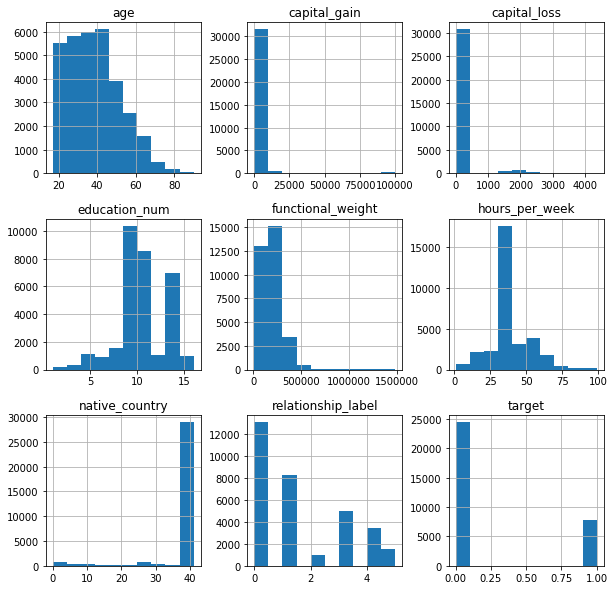

In [9]:
data_raw.hist(figsize=(10, 10));

In [10]:
# V 3
data = data_raw.loc[:, ['age','functional_weight','capital_gain','capital_loss',
                        'hours_per_week', 'relationship_label', 'education_num',
                        'native_country', 'target']]
data.head()

age  functional_weight  capital_gain  capital_loss  hours_per_week  \
21041   66              36364             0          2267              40   
7375    32             142675             0             0              40   
25487   28             161087             0             0              45   
11682   39              32146             0             0              60   
6720    31             347166          4650             0              40   

       relationship_label  education_num  native_country  target  
21041                   0              9              39       0  
7375                    1              9              39       0  
25487                   1             10              23       0  
11682                   1             14              39       0  
6720                    3             10              39       0

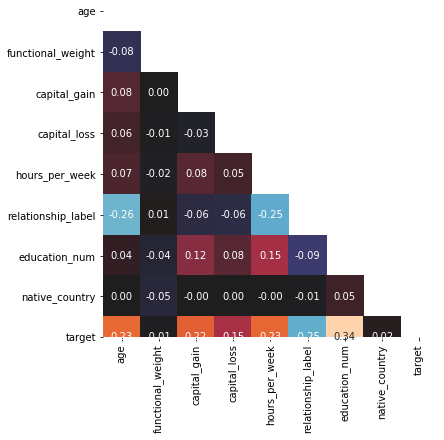

In [11]:
plt.figure(figsize=(6,6))

corr_matrix = data.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

sns.heatmap(lower, annot=True, fmt='.2f', cbar=False, center=0);

In [12]:
high_corr = [
    column for column in lower.columns if any((lower[column] > 0.6)|(lower[column] < -0.6))
]
high_corr

[]

####  We don't have features with high Correlation at Target and with each other.

In [13]:
other_features = [col for col in data.columns if col not in high_corr and col!='target']
other_features

['age',
 'functional_weight',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'relationship_label',
 'education_num',
 'native_country']

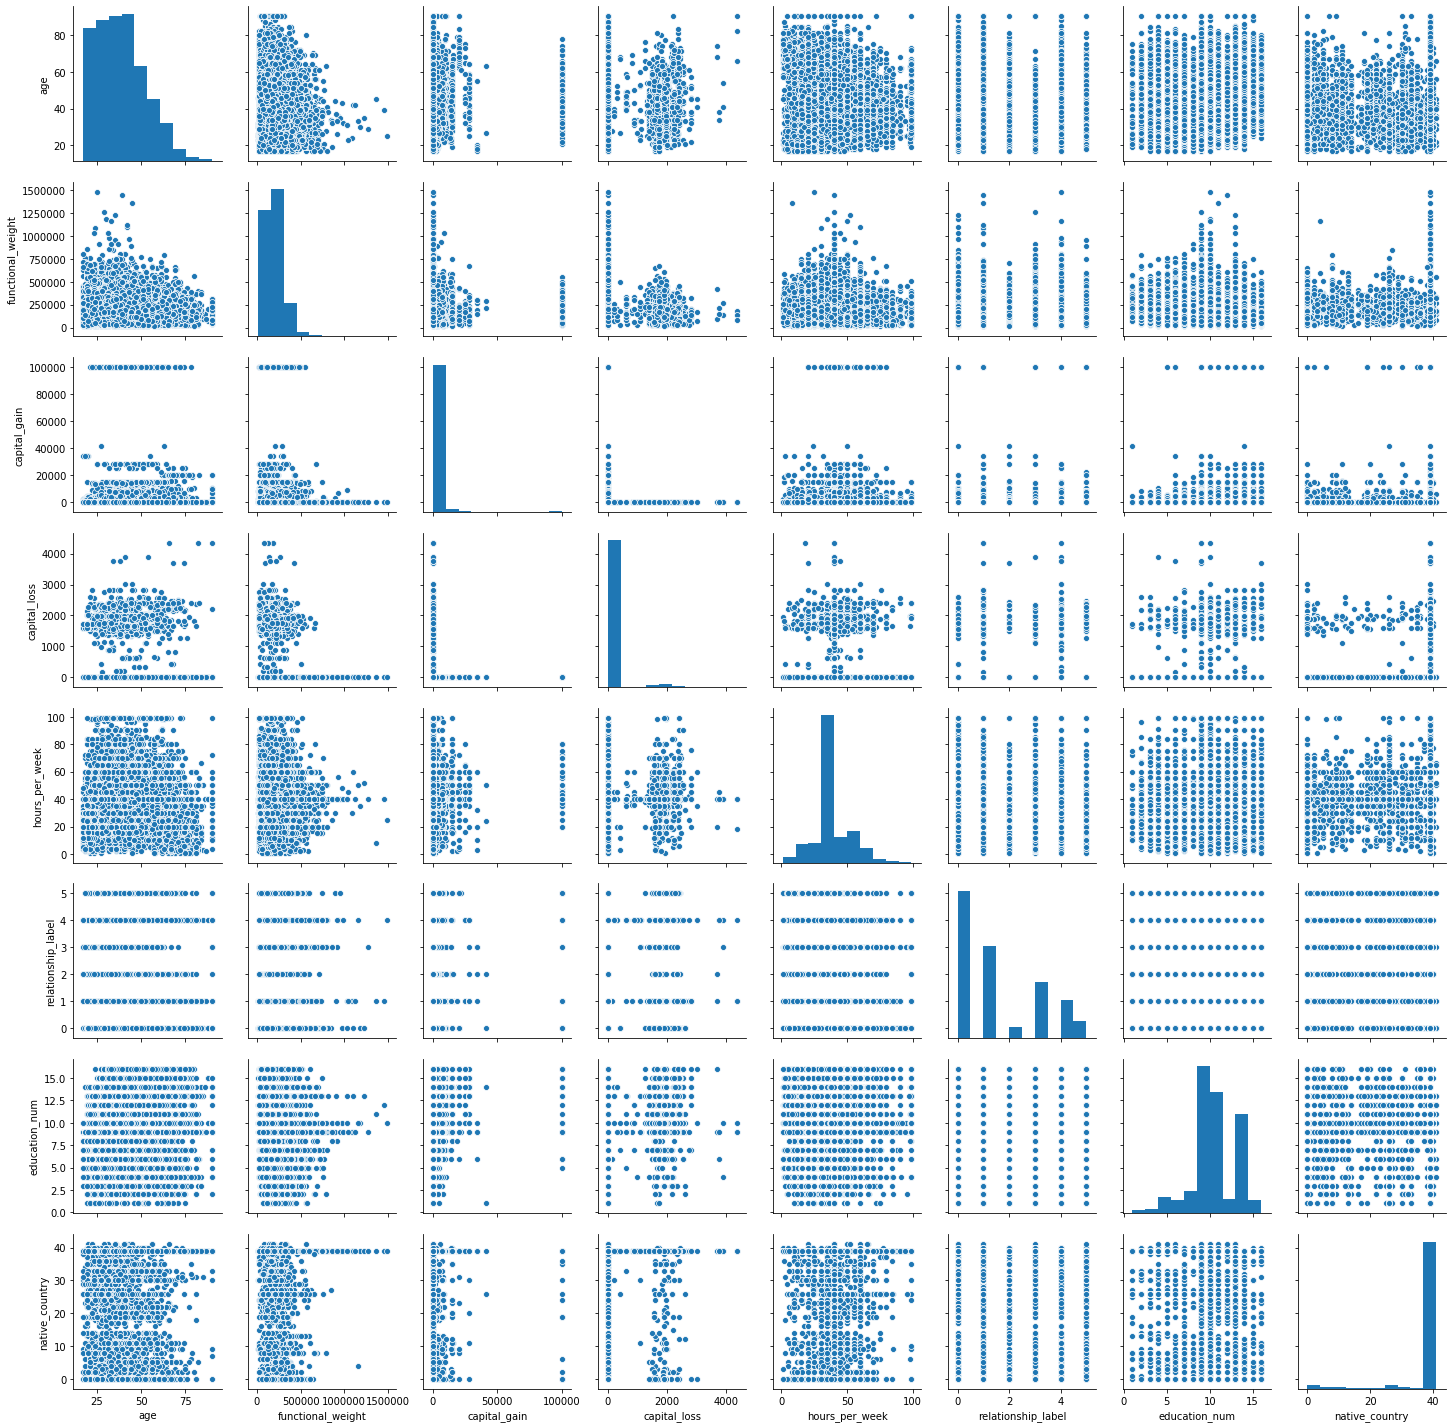

In [14]:
sns.pairplot(data[other_features]);

## **Simplest methods**

### **3-sigmas** 

In [15]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [16]:
def get_column_outliers(data, columns=None, function=outlier_std, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns
        
    outliers = pd.Series(data=[False]*len(data), index=data_features.index, name='is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] = True
    
    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    
    return comparison_table, outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))    

In [17]:
data_features = data.iloc[:, :-1]
data_features.head(1)

age  functional_weight  capital_gain  capital_loss  hours_per_week  \
21041   66              36364             0          2267              40   

       relationship_label  education_num  native_country  
21041                   0              9              39

In [18]:
comparison_table, std_outliers = get_column_outliers(data_features)
anomalies_report(std_outliers)

Total number of outliers: 4017
Percentage of outliers:   12.46%


In [19]:
comparison_table

upper_bound    lower_bound  anomalies_count  \
age                     79.504974      -2.342387            118.0   
functional_weight   506102.854226 -126774.491949            345.0   
capital_gain         23335.993895  -21170.984495            214.0   
capital_loss          1295.202704   -1120.955953           1452.0   
hours_per_week          77.430329       3.429730            432.0   
relationship_label       6.262540      -3.373382              0.0   
education_num           17.798435       2.360399            215.0   
native_country          60.187850      13.254558           1489.0   

                    anomalies_percentage  
age                             0.366062  
functional_weight               1.070265  
capital_gain                    0.663875  
capital_loss                    4.504421  
hours_per_week                  1.340158  
relationship_label              0.000000  
education_num                   0.666977  
native_country                  4.619203

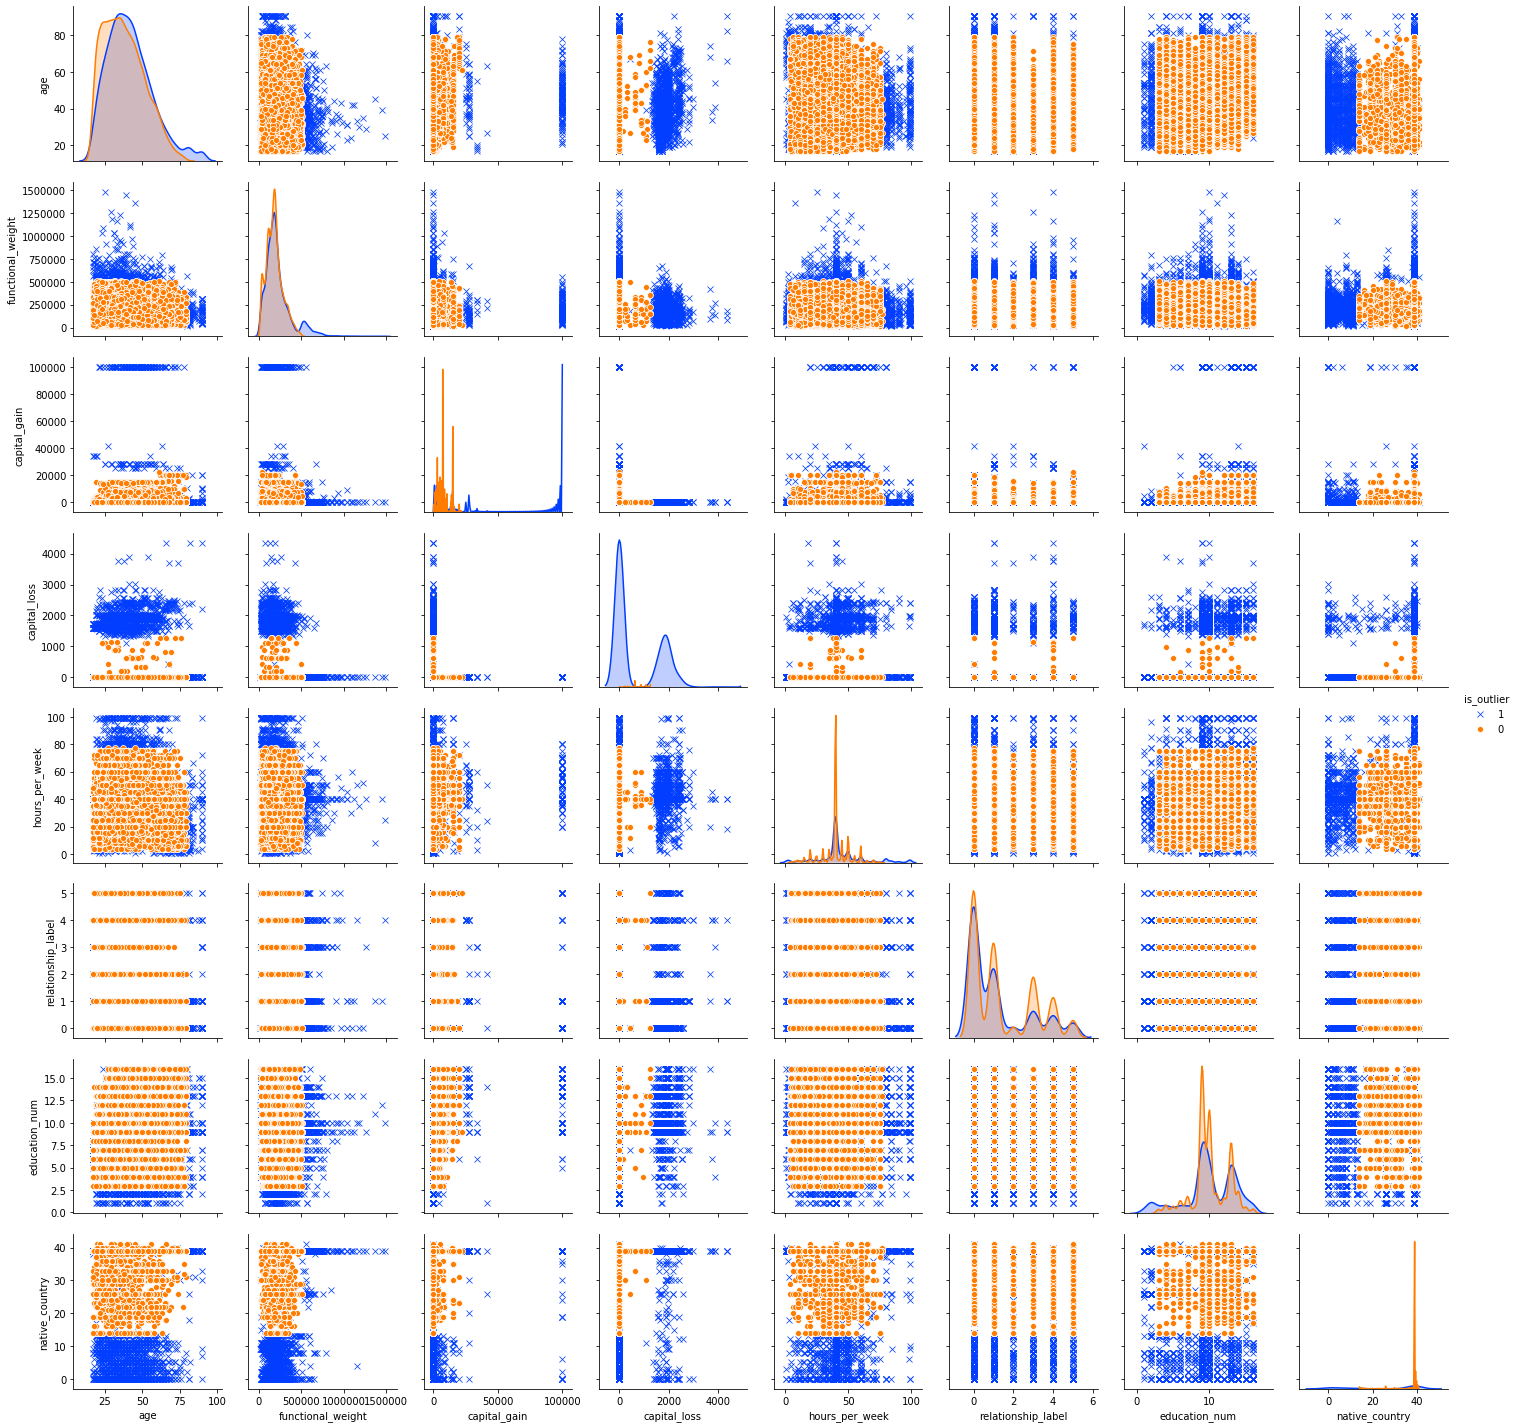

In [20]:
# For vizualization , if need:

labeled_data = data_features.copy()
labeled_data['is_outlier'] = std_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             markers=['x', 'o'],  palette='bright');

### **Interquartile deviation**

In [21]:
def outlier_iqr(data, col, threshold=3):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    up_bound = data[col].quantile(0.75) + (IQR * threshold)
    low_bound = data[col].quantile(0.25) - (IQR * threshold)
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [22]:
comparison_table, iqr_outliers = get_column_outliers(data_features, function=outlier_iqr)
anomalies_report(iqr_outliers)

Total number of outliers: 10765
Percentage of outliers:   33.40%


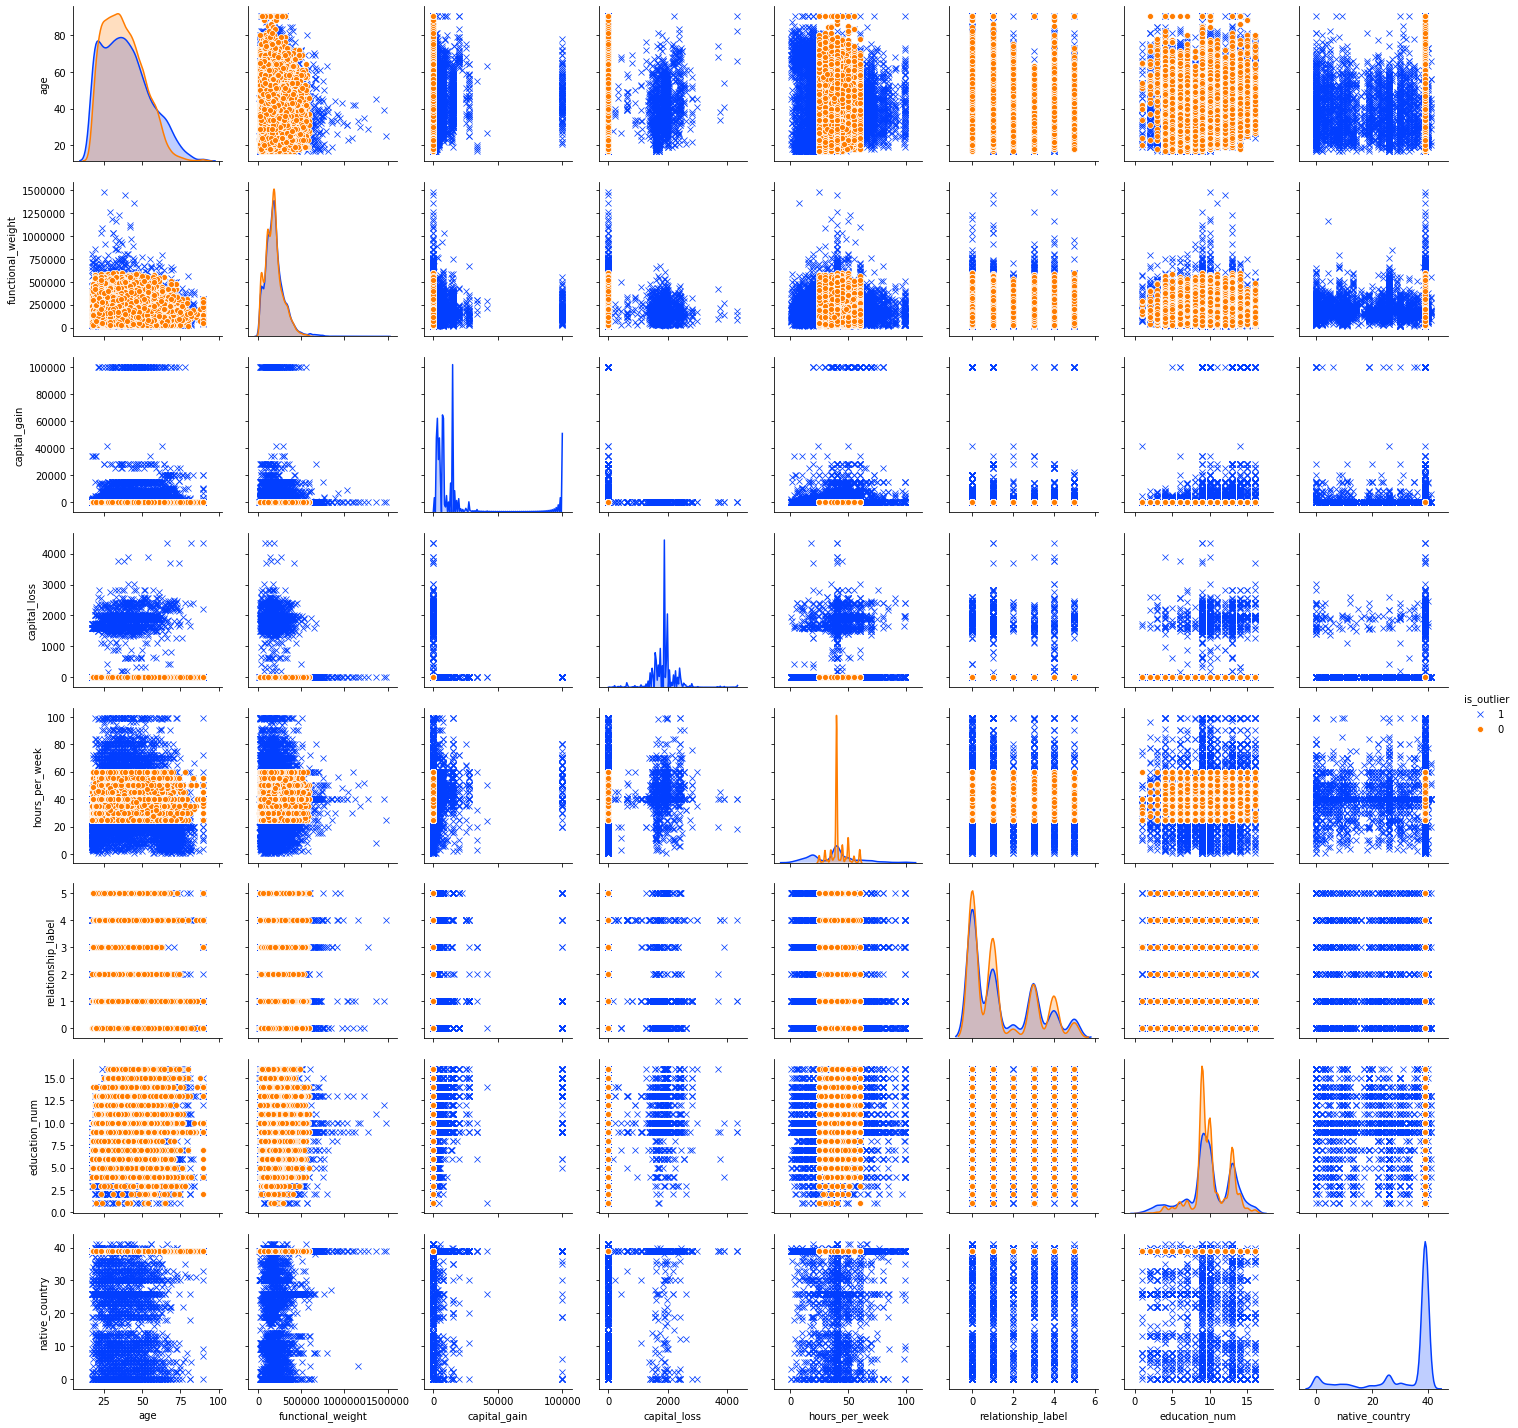

In [23]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = iqr_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             markers=['x', 'o'],  palette='bright');

## **Clusterization**

### **Distance-based** 

In [24]:
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler

class DistanceOutliers(BaseEstimator):
    """
    Distance based outlier detector model
    
    Fit method calculates centroid of training samples and
    using `metric` get distances from centroid to train samples.
    Having distances - we calculate `threshold` based on `percentile`.
    
    Predict method uses `threshold` and `metric` to determine, whether
    distance to sample from centroid is too large -> outlier.
    
    -----------
    Parameters:
    
    - metric: string, default - euclidean
        metric to use for distance calculation (see scipy.spatial.distance.cdist)
        
    - percentile: float in range [0, 100]
        hyperparameter which sets the threshold for anomalies
    """
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

In [25]:
# Since we are dealing with distances, you need to make sure that all data is on the same scale

scaler = RobustScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(data_features), 
    columns=data_features.columns
)

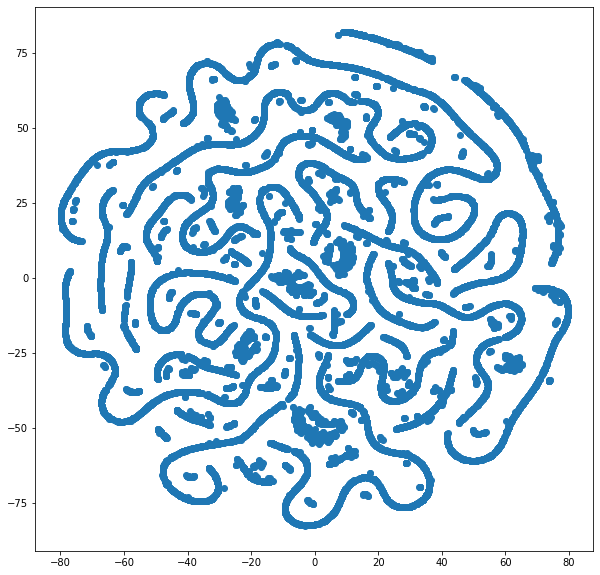

In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=50)
tsne_transformed = tsne.fit_transform(data)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1]);

In [27]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=90)
euclidian_model.fit(data)
euclidian_outliers = euclidian_model.predict(data)
anomalies_report(euclidian_outliers)

Total number of outliers: 3224
Percentage of outliers:   10.00%


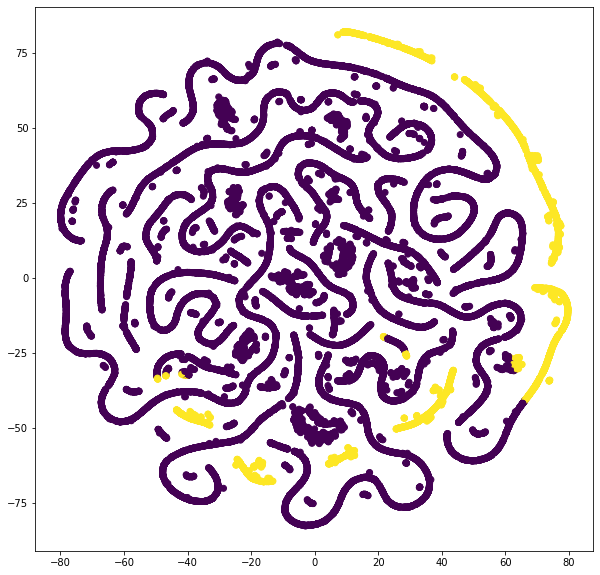

In [28]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=euclidian_outliers);

Total number of outliers: 3224
Percentage of outliers:   10.00%


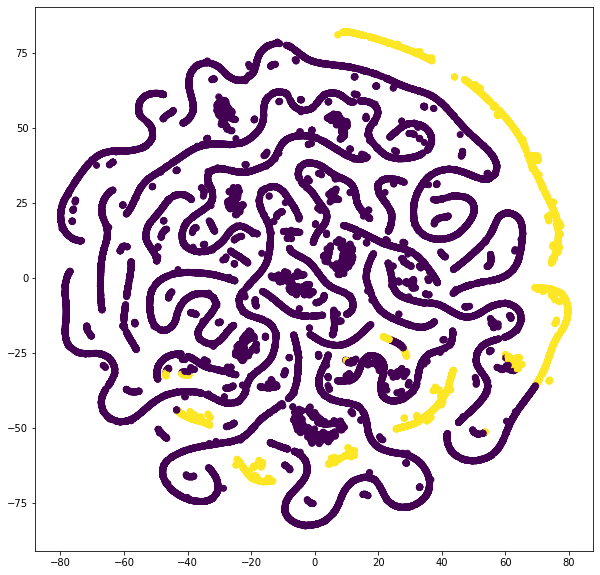

In [29]:
citiblock_model = DistanceOutliers(metric='cityblock', percentile=90)
citiblock_model.fit(data)
cityblock_outliers = citiblock_model.predict(data)
anomalies_report(cityblock_outliers)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=cityblock_outliers);

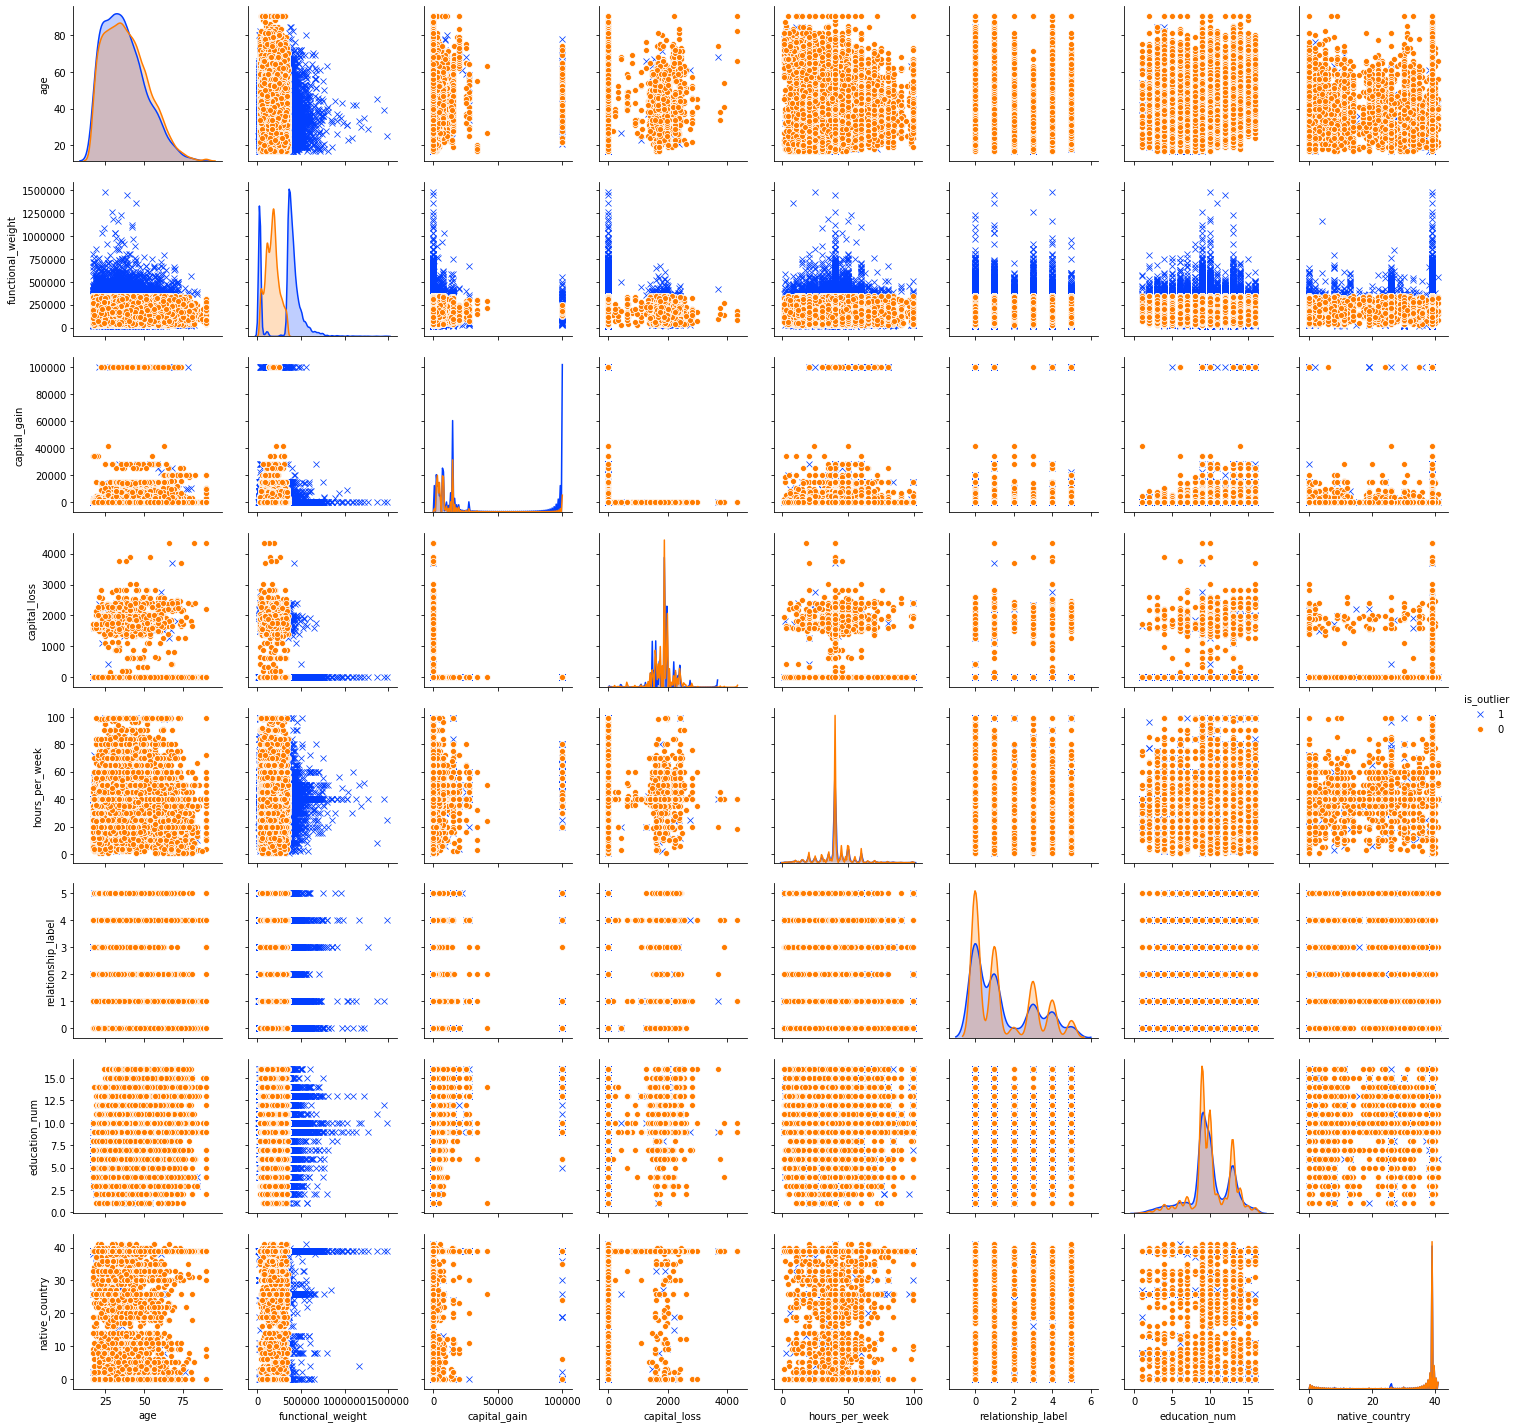

In [30]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = cityblock_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             markers=['x', 'o'],  palette='bright');

## **Unsupervised model-based**

In [31]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=0.1, gamma='auto')
one_class_svm.fit(data)
svm_outliers = one_class_svm.predict(data)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

In [32]:
anomalies_report(svm_outliers)

Total number of outliers: 13966
Percentage of outliers:   43.33%


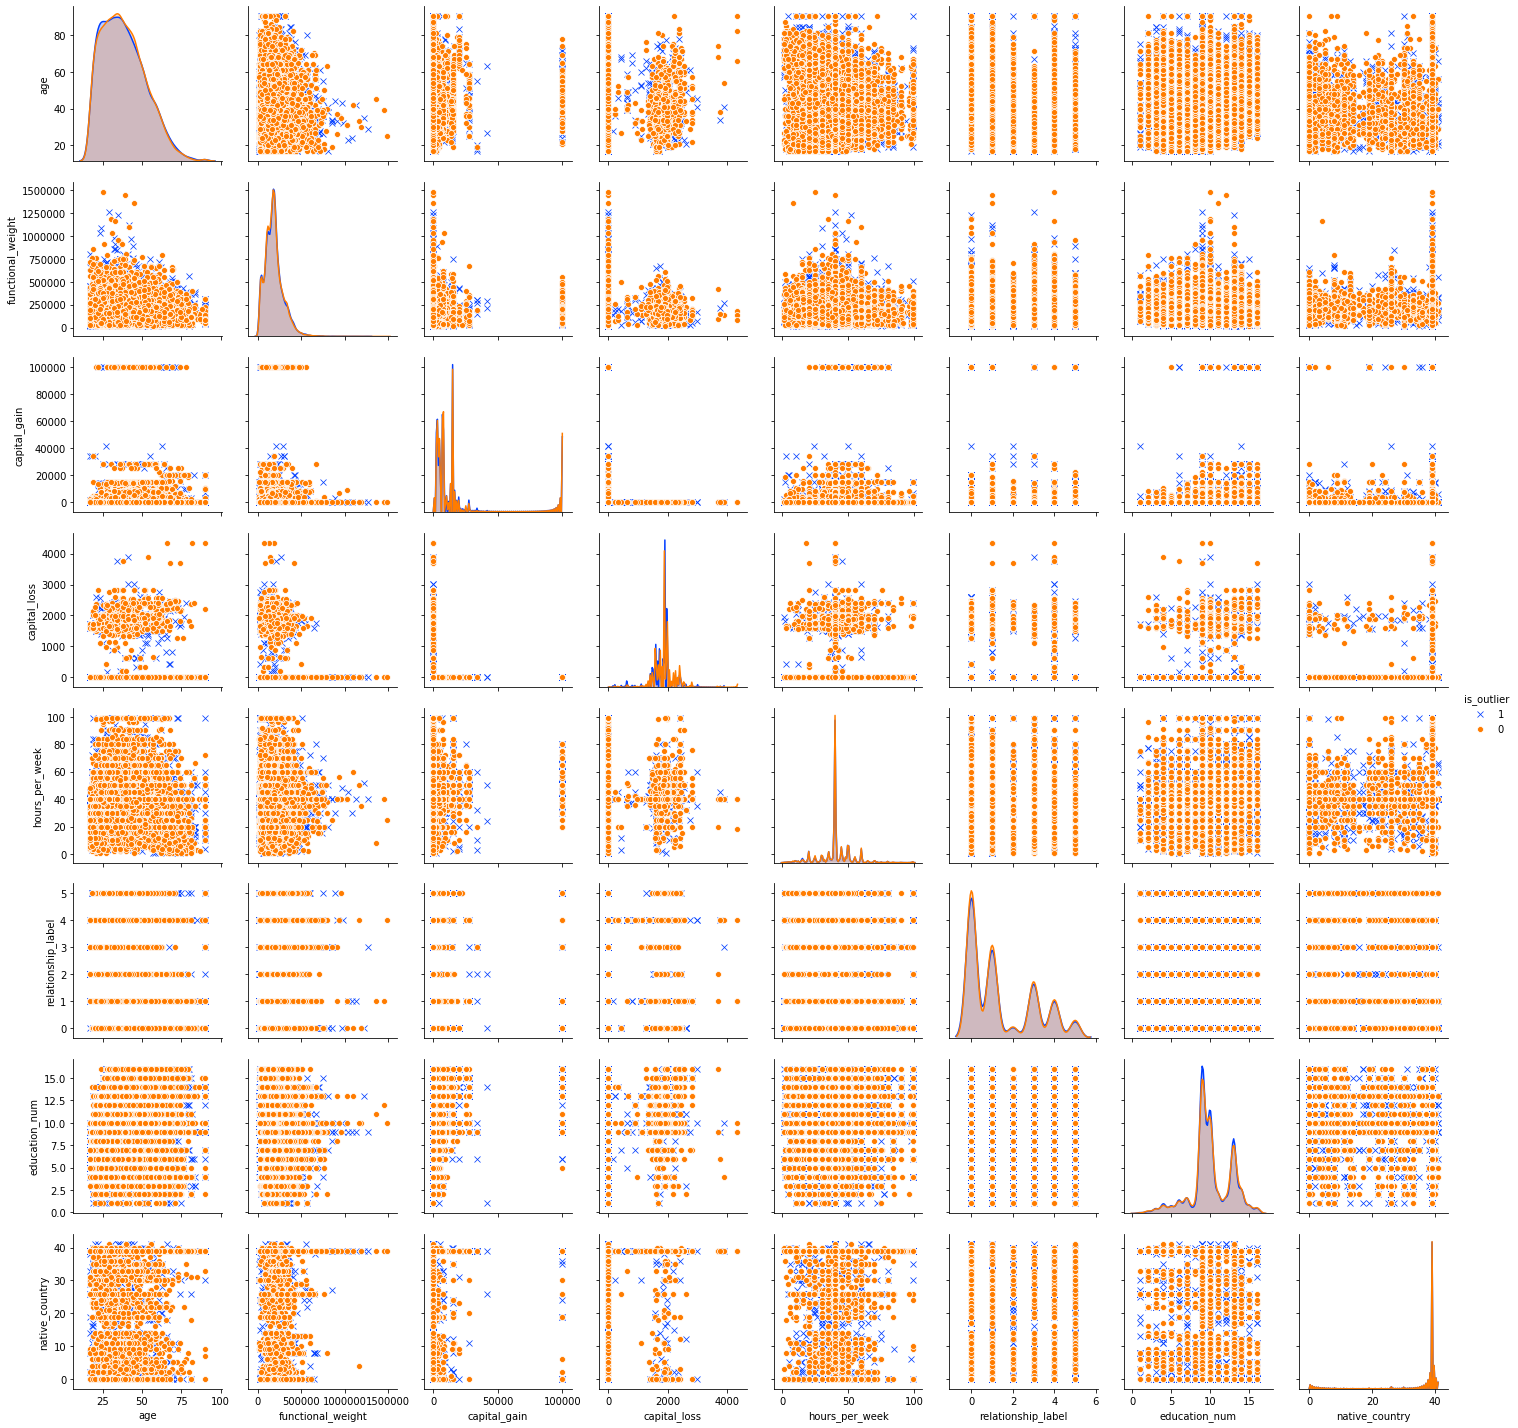

In [33]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = svm_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             markers=['x', 'o'],  palette='bright');

###  **Isolation Forest** 

In [34]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, contamination=0.1, 
                                   max_features=1.0, bootstrap=True, behaviour="new")
isolation_forest.fit(data)

isolation_outliers = isolation_forest.predict(data)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

In [35]:
anomalies_report(isolation_outliers)

Total number of outliers: 3224
Percentage of outliers:   10.00%


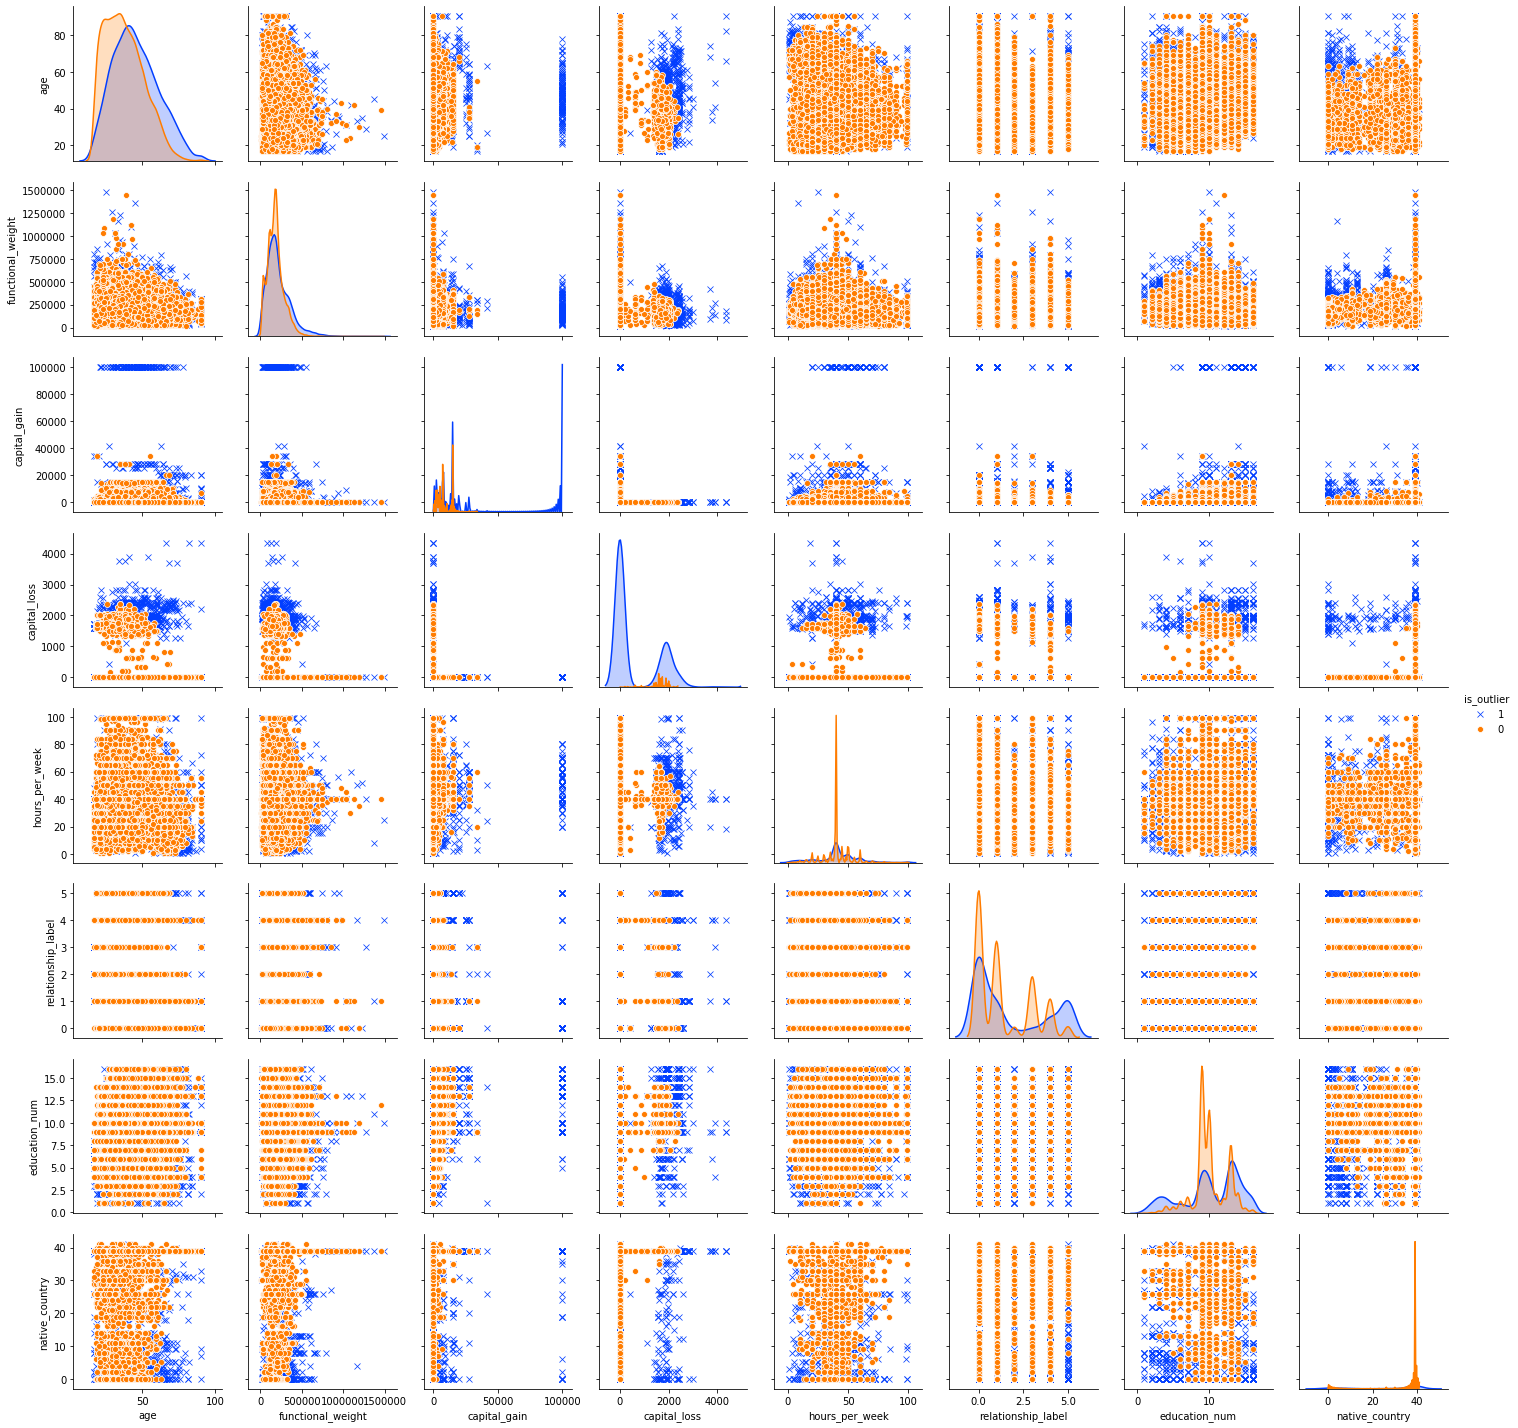

In [36]:
labeled_data = data_features.copy()
labeled_data['is_outlier'] = isolation_outliers

sns.pairplot(data=labeled_data, vars = other_features,
             hue='is_outlier', hue_order=[1, 0],
             markers=['x', 'o'],  palette='bright');

# **Final comparison**

In [37]:
summary = np.concatenate((
    [std_outliers], 
    [iqr_outliers], 
    [euclidian_outliers], 
    [cityblock_outliers],
    [svm_outliers],
    [isolation_outliers]
))

In [38]:
summary = pd.DataFrame(
    summary.T, 
    columns=['std', 'iqr', 'euclid', 'cityblock', 'svm', 'isolation']
)
summary.head(3)

std  iqr  euclid  cityblock  svm  isolation
0    1    1       0          0    1          1
1    0    0       0          0    1          0
2    0    1       0          0    1          0

In [39]:
summary.sum(axis=1).value_counts()

1    11621
0    10975
2     4701
3     3101
4     1272
5      384
6      181
dtype: int64

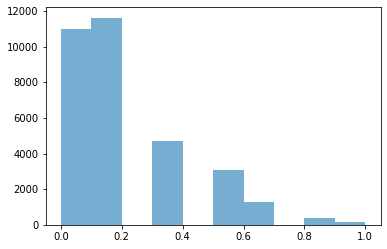

In [40]:
outlier_score = summary.mean(axis=1)
plt.hist(outlier_score, alpha=0.6);

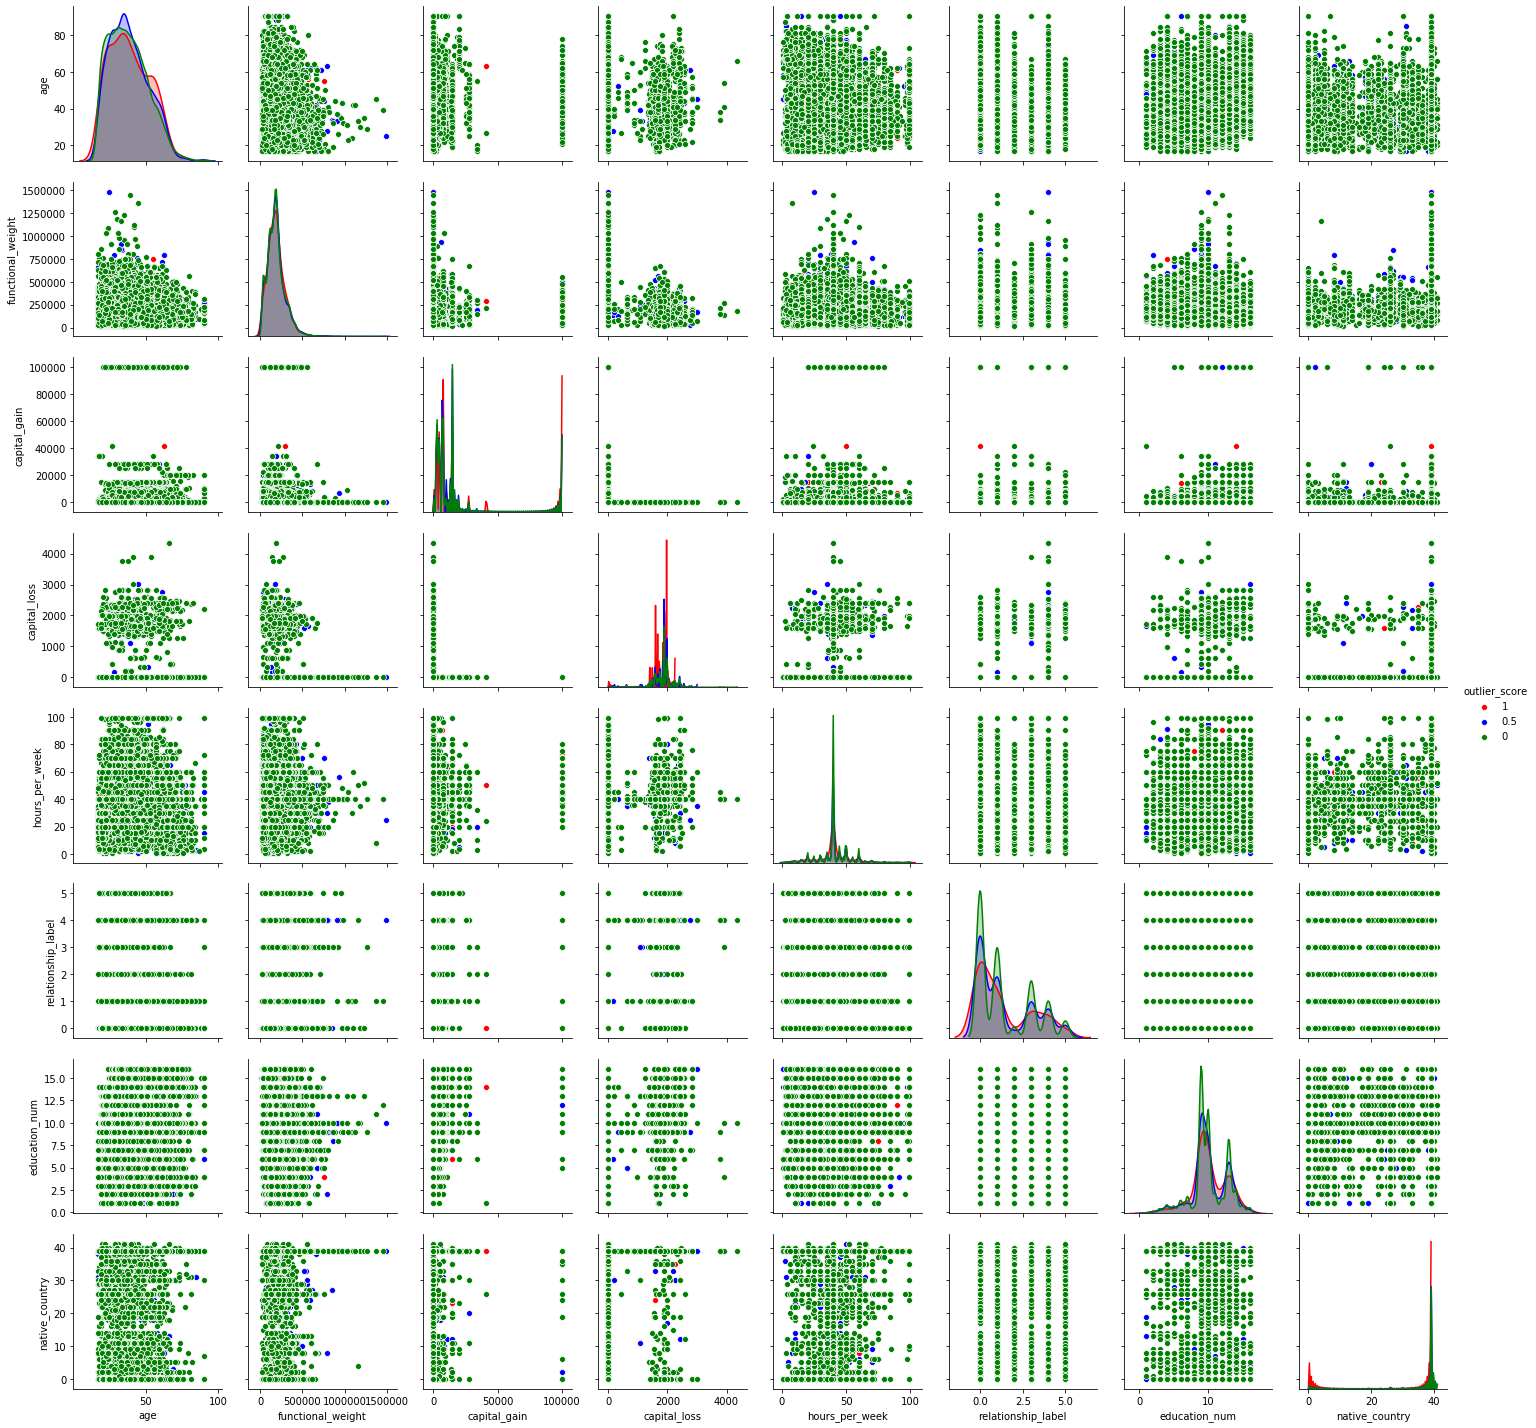

In [41]:
simple_score = outlier_score.apply(lambda x: 0 if x < 0.4 else 0.5 if x < 0.8 else 1)

labeled_data = data_features.copy()
labeled_data['outlier_score'] = simple_score

custom_palette = {0:'g', 0.5:'b', 1.0:'r'}

sns.pairplot(data=labeled_data, vars=other_features, 
             hue='outlier_score',
             hue_order=[1, 0.5, 0],
             palette=custom_palette
)

### Save MASK for cleaning outlier in File. ( filter  value <= 6)

In [42]:

summary.to_csv('my_summary_outlier_mask.csv') # save as csv file (sum.Max = 7)

#  Data for modeling

### This data from data_row without categorical features and not scaled

###  Threshold for the number of filters for cleaning outliers ( if threshold  == 6 , its Full Dataset )

## RandomForest Base model

In [43]:
# Reset index after Random Split
data = data.reset_index()

In [44]:
sum_of_filters = {  7: 'No Outlier',  
                    6: 'Min count',
                    5: 'Average level',
                    4: 'More than average',
                    3: 'Max level'
}
classifiers = sum_of_filters.values()

In [45]:
outliers_count = []
roc_aucs = []
scores = []
f1_scores = []
outliers_percent = []



for key,value in sum_of_filters.items():

    mask_clear_all = summary.sum(axis=1) < key
    df_clear = data[mask_clear_all]

    X_df = df_clear.drop(['target'], axis = 1)
    y_df = df_clear['target']

    X_train, X_test, y_train, y_test = train_test_split( X_df, y_df,test_size=0.2,
                                                        random_state=42)

    model = RandomForestClassifier(oob_score=True)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred_prob[:,1], pos_label=1)
    
    roc_auc = auc(fpr, tpr)
    score = accuracy_score(y_test,y_pred)
    f_score = f1_score(y_test, y_pred)    
    out_perc = (data_raw.shape[0] - X_df.shape[0]) * 100 / data_raw.shape[0]
    count_out = data_raw.shape[0] - X_df.shape[0] 
    
    outliers_percent.append(out_perc)
    outliers_count.append(count_out)
    roc_aucs.append(roc_auc)
    scores.append(score)
    f1_scores.append(f_score)


In [46]:
about_data_for_fit = pd.DataFrame(scores, index = classifiers,
            columns = ['Accuracy Score', ])
about_data_for_fit['ROC AUC'] = roc_aucs
about_data_for_fit['F1 score'] = f1_scores
about_data_for_fit['Amount anomaly'] = outliers_count
about_data_for_fit['Percentage anomaly'] = outliers_percent
about_data_for_fit.sort_values(by = 'Accuracy Score', ascending = False)

Accuracy Score   ROC AUC  F1 score  Amount anomaly  \
No Outlier               0.841322  0.871584  0.643181               0   
Average level            0.841175  0.876486  0.635507             565   
Min count                0.835127  0.865154  0.619099             181   
More than average        0.833882  0.865227  0.596967            1837   
Max level                0.830952  0.854231  0.561103            4938   

                   Percentage anomaly  
No Outlier                   0.000000  
Average level                1.752753  
Min count                    0.561501  
More than average            5.698775  
Max level                   15.318753